In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', font_scale=1.3, palette='Set2')
%matplotlib inline
from collections import defaultdict
from scipy.stats import entropy
import plotly.plotly as py
import plotly.graph_objs as go

In [25]:
out_path = './'

data = pd.read_csv('./enrichment.csv', index_col=0) # read in our data
data['is_HIV'] = ['HIV' in row['virus'] for idx, row in data.iterrows()]
metadata_cols = ['virus', 'start', 'end', 'sequence', 'strains', 'is_HIV'] # nonnumeric columns
data.drop(['start.1', 'end.1'], axis=1,inplace=True)
sample_cols = [c for c in data.columns.values if c not in metadata_cols] # data columns

print data.head() # peek at the first few rows

                   beads   447-52D    PGT145     ZV-48     240-D     VRC01  \
id                                                                           
1               0.766254  0.738257  0.869706  0.510188  0.521146  0.350014   
100             0.569907  0.346760  0.353781  0.553605  0.570604  0.449471   
1001            1.212884  0.579587  0.684727  0.748269  0.967912  1.235574   
1002            1.908262  3.553879  2.411806  2.414700  3.720523  3.500491   
1008.1177.1346  0.678575  0.519033  0.685821  0.787341  0.624349  0.704500   

                     NS1  input     QA013      DV63  virus  start   end  \
id                                                                        
1               0.561547    1.0  0.451529  0.701610  CHIKV      1   118   
100             0.420955    1.0  0.143271  0.828199  CHIKV   5941  6058   
1001            0.384251    1.0  0.330272  1.177388  DENV2   7381  7498   
1002            2.805625    1.0  1.109908  2.247035  DENV2   7441  7558   
100

In [41]:
def calc_percentiles(series):
    N = float(len(series))
    def calc_value_percentile(x):
        values_below = series < x
        N_values_below = float(values_below.sum())
        return N_values_below / N
    
    return series.map(calc_value_percentile)

enrichment_percentiles = data[sample_cols].apply(calc_percentiles, axis=0)

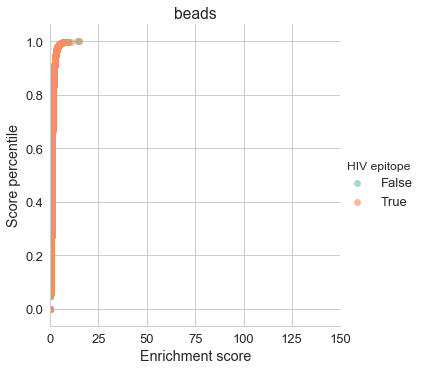

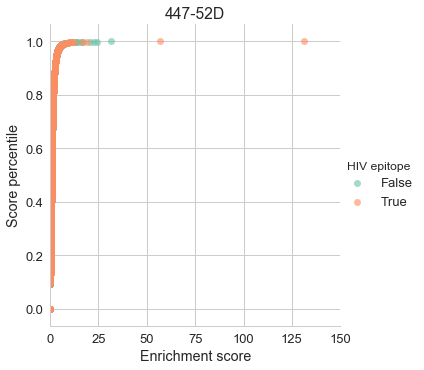

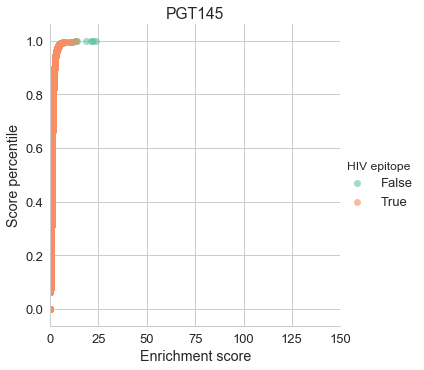

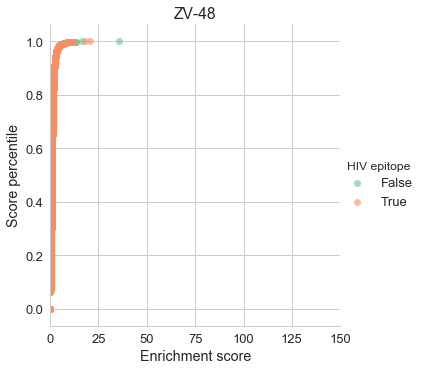

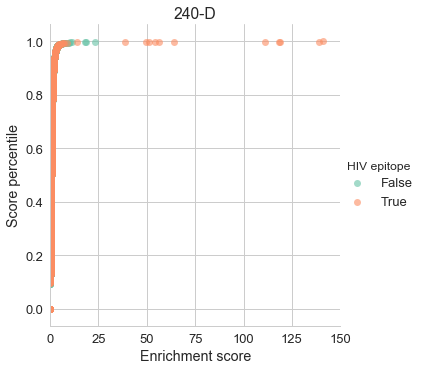

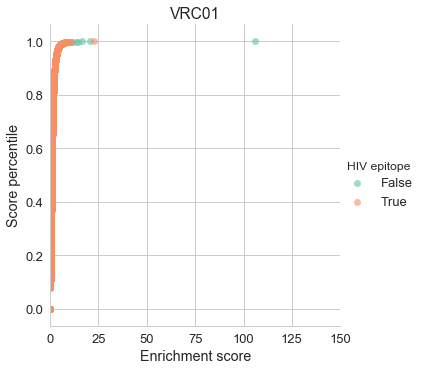

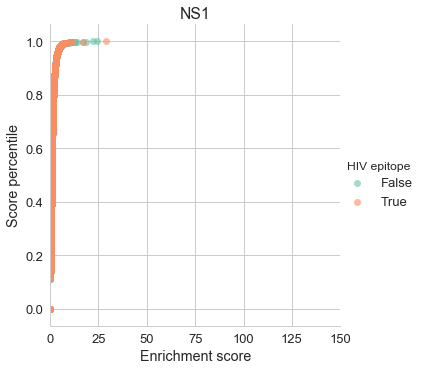

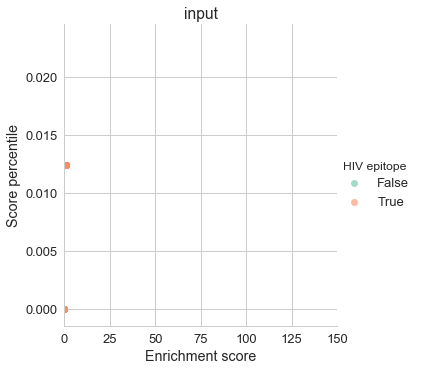

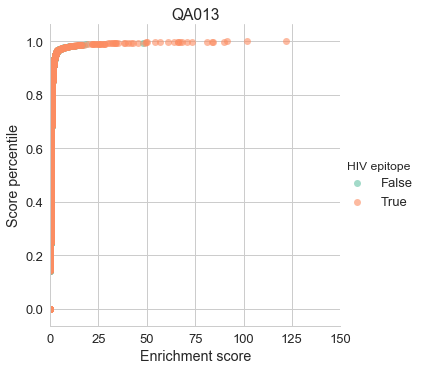

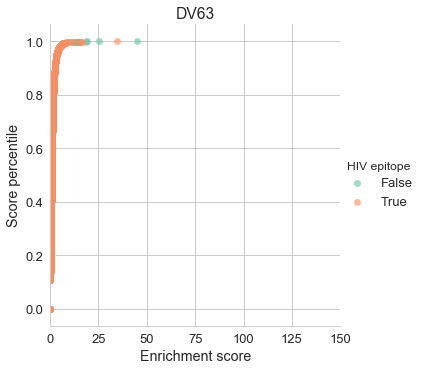

In [49]:
def plot_sera_distrib(serum):
    
    values = {'x': data[serum],
              'y': enrichment_percentiles[serum],
              'hue': data['is_HIV']}
    values = pd.DataFrame(values)
    
    ax = sns.lmplot('x', 'y', values, hue='hue', fit_reg=False, scatter_kws={'alpha': 0.6})
    ax._legend.set_title('HIV epitope')

    plt.xlim((0,150))
    plt.ylabel('Score percentile')
    plt.xlabel('Enrichment score')
    plt.title(serum)
    plt.show()
    plt.close()
    
for serum in sample_cols:
    plot_sera_distrib(serum)

In [53]:
def calc_entropy(row):
    total = row[sample_cols].sum()
#     total = row.sum()
    if total == 0:
        return 0.
    distrib = row[sample_cols].map(lambda x: float(x) / float(total))
#     distrib = row.map(lambda x: float(x) / float(total))

    return entropy(distrib.values)

data['entropy'] = data.apply(calc_entropy, axis=1)
data['max_enrichment'] = data[sample_cols].max(axis=1)

In [58]:
data['virus'] = data['virus'].map(lambda x: 'HIV' if 'HIV' in x else x)

In [59]:
def find_all_oligos(virus, site, data=data):
    '''
    find all the integer indices 
    in the dataframe that correspond to oligos 
    containing that site
    '''
    indices = np.where((data['virus']==virus) &
                 (data['start'] <= site) & 
                 (site <= data['end']))
    return indices[0]
    
def aggregate_site(virus, site, data):
    '''Return a series of the mean value of each column for all oligos containing the input site'''
    indices = find_all_oligos(virus, site, data)
    entries = data.iloc[indices]
    agg = entries.mean(axis=0)
    return agg
        
def aggregate_virus_sites(virus, data=data):
    ''' For all sites in the viral genome in the dataset, fetch the aggregated values of all oligos containing that site'''
    first_site = data.loc[data['virus'] == virus]['start'].min()
    last_site = data.loc[data['virus']==virus]['end'].max()
    
    sites = range(first_site, last_site)
    aggregated_sites = { site: aggregate_site(virus, site, data) for site in sites }

    df = pd.DataFrame.from_dict(aggregated_sites, orient='index')
    df.to_csv(out_path + virus + '_sitewise_enrichment.csv')
    return df

site_maps = {virus: aggregate_virus_sites(virus) for virus in pd.unique(data['virus'])}

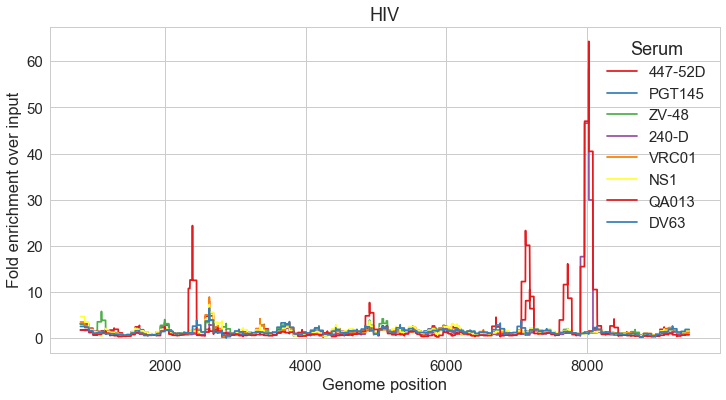

In [61]:
def plot_binding_footprint(virus, serum, ax=None):
    
    values = site_maps[virus][serum]
    
    if ax == None:
        fig, ax = plt.subplots(figsize=(12, 6))
    
    ax.plot(values.index.values, values.values, label=serum)
    return ax

def plot_all_binding_footprints(virus):
    values = site_maps[virus]
    
    fig, ax = plt.subplots(figsize=(12,6))
    for serum in sample_cols:
        if serum not in ['beads', 'input']:
            plot_binding_footprint(virus, serum, ax)
    plt.legend(title='Serum')
    ax.set_title(virus)
    ax.set_xlabel('Genome position')
    ax.set_ylabel('Fold enrichment over input')
    plt.show()
        
for virus in ['HIV']:#sample_cols:
    plot_all_binding_footprints(virus)

In [63]:
def plot_interactive_binding_footprints(virus):
    values = site_maps[virus]
    traces = []
    
    for serum in sample_cols:
        if serum in ['input', 'beads']:
            continue
            
        vals = values[serum]
        
        trace = go.Scatter(
            x = vals.index.values,
            y = vals.values,
            mode = 'lines',
            name = serum)
        
        traces.append(trace)
    
    layout = dict(title = 'Oligos from %s'%virus,
              xaxis = dict(title = 'Genomic position'),
              yaxis = dict(title = 'Fold enrichment by sera'),
              )
    
    py.iplot(traces, filename=virus)


for virus in ['HIV']:#sample_cols:
    plot_interactive_binding_footprints(virus)

The draw time for this plot will be slow for all clients.
